In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random
import string

def label_generator():
  existed_label = set()
  
  def get_random_string(length=8):
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str
  
  while True:
    random_generated_label = get_random_string()
    if random_generated_label not in existed_label:
      existed_label.add(random_generated_label)
      break

  return random_generated_label

In [9]:
class Value:
  
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    #  grad to 0 means it has no effect
    self.grad = 0
    # Use set to filter out duplicate Value in children tuple
    self._prev = set(_children)
    self._op = _op
    if label == "":
      self.label = label_generator()
    else:
      self.label = label
  
  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")
    return out
  
  def __sub__(self, other):
    out = Value(self.data - other.data, (self, other), "-")
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), "*")
    return out
  
# a = Value(2.0, label="a")
# b = Value(-3.0, label="b")
# c = Value(6.0, label="c")
# e = b * c
# e.label = "e"
# d = a + e
# d.label = "d"
# f = Value(-2.0, label="f")
# L = d * f
# L.label = "L"


In [32]:
from graphviz import Digraph
ps = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

ps.node(name='parrot')
ps.node(name='dead')
# ps.edge('parrot', 'dead')

ps

[Value(data=2.0), Value(data=-3.0), Value(data=6.0), Value(data=-18.0), Value(data=-16.0)]


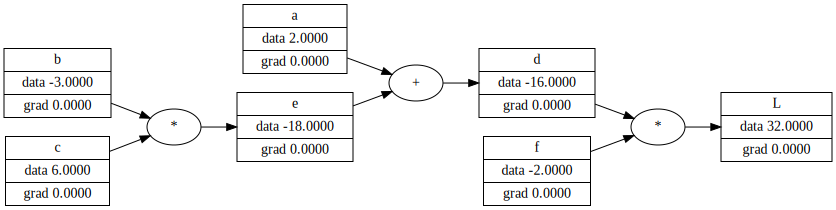

In [10]:
from graphviz import Digraph

def get_topo_order(root):
  topo_order = []
  visited = set()
  def topo_sort_dfs(node, visited, topo_order):
    if node not in visited:
      visited.add(node)
      for child in node._prev:
        topo_sort_dfs(child, visited, topo_order)
      topo_order.append(node)
  topo_sort_dfs(root, visited, topo_order)
  return topo_order

print(get_topo_order(d))

def draw_dot_using_topo(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  topo_order = get_topo_order(root)
  for node in topo_order[::-1]:
    node_uid = str(id(node))
    dot.node(name = node_uid, 
             label = "{} | data {:.4f} | grad {:.4f}".format(node.label, node.data, node.grad), 
             shape = "record")
    if node._op:
      dot.node(name = node_uid + node._op,
               label = node._op)
      dot.edge(node_uid + node._op, node_uid)
      for child in node._prev:
        child_uid = str(id(child)) 
        dot.edge(child_uid, node_uid + node._op)
  return dot

draw_dot_using_topo(L)


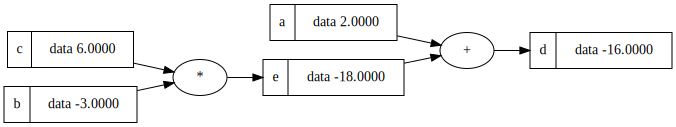

In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(d)

-1.9999999999953388


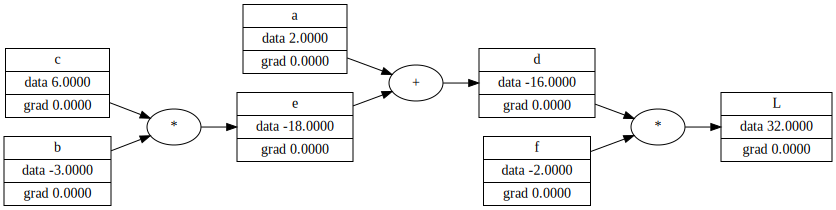

In [29]:
# Calcuate numeric differentiation of L with respect to a
def lol():
  h = 0.0001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(6.0, label="c")
  e = b * c
  e.label = "e"
  d = a + e
  d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f
  L.label = "L"
  L1 = L.data

  a = Value(2.0 + h, label="a")
  b = Value(-3.0, label="b")
  c = Value(6.0, label="c")
  e = b * c
  e.label = "e"
  d = a + e
  d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f
  L.label = "L"
  L2 = L.data

  print((L2 - L1) / h)

lol()

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(6.0, label="c")
e = b * c
e.label = "e"
d = a + e
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

draw_dot_using_topo(L)



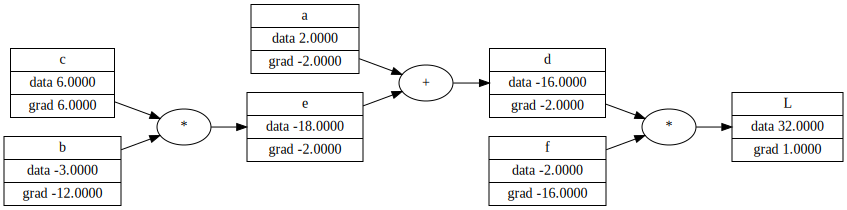

In [30]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
a.grad = d.grad * 1.0
e.grad = d.grad * 1.0
b.grad = e.grad * c.data
c.grad = e.grad * b.data

draw_dot_using_topo(L)

Value(data=27.760448)


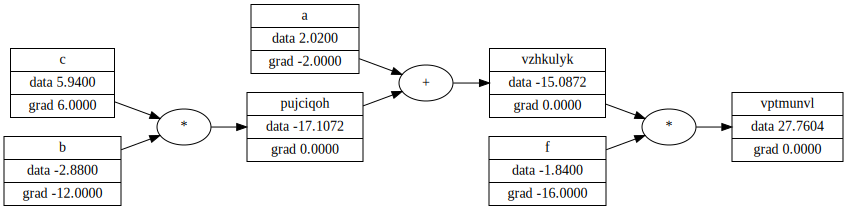

In [31]:
a.data -= 0.01 * a.grad
b.data -= 0.01 * b.grad
c.data -= 0.01 * c.grad
f.data -= 0.01 * f.grad

e = b * c
d = a + e
L = d * f

print(L)
draw_dot_using_topo(L)